In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py, time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mat
import seaborn as sb
import tensorflow as tf
import scipy

import sys
sys.path.append('../../../..')
import mutagenesisfunctions as mf
import bpdev as bd
import helper
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency

import contacts

from Bio import AlignIO
import time as time
import pandas as pd
np.random.seed(42)

# Contact map by scatter plot - both SoM and infernal compared to cWW int

### Get infernal SS (from R-scape lol)

In [2]:
#first get the nested SS (from R-scape for now)
#open the sto file to see if pseudoknots are present
fam = 'RF00010'
cykfile = '../../../data_marks/%s/%s_red.cyk.sto'%(fam,fam)
SS = ''
with open(cykfile, 'r') as f1:
    for line in f1:
        if line[:13] == '#=GC SS_cons ':
            line = line.split()
            SS = SS + line[2]
            
nest_coords = bd.bp_coords(SS)
nest_coords = nest_coords[:len(nest_coords)//2]

### Get SoM results and cWW annotation

In [3]:
numhidden = 512
min_dist = 5.0

#get scores
arrayspath = '../../marks/Arrays/%s_mlp_%s_red.npy'%(fam,numhidden)
hol_mut2 = np.load(arrayspath)
seqlen,_, dims,_ = hol_mut2.shape
C = bd.get_wc(arrayspath, seqlen, dims, bpugSQ=0, denoise='APC')

#get coordinates
C[np.tril_indices(seqlen)] = np.min(C)
bp_stretch = np.ravel(C)
minval = np.sort(bp_stretch)[::-1][-1] #just gets the minimum value - can be changed to a different idx
bs = np.where(C > minval)
idx = np.argsort(C[bs])
x = bs[0][idx] #sorts the x and y coords in order from lowest to highest so highest scores will be plotted last
y = bs[1][idx]

score_col = [C[xx,yy] for xx,yy in zip(x,y)] #gets the scores for each coordinate in the needed order


#Load in the EC annotation
ECannotfile = '../../marks/%s/%s.EC.interaction.txt'%(fam,fam) 
EC_df = pd.read_csv(ECannotfile, delimiter='\s+')

######### QUALITATIVE CONTACTS ###########

#Top L/2 EC scores
topEC = EC_df.loc[:seqlen//2, ['Rfam_reduced_position1', 'Rfam_reduced_position2']]
#All cWW annotated interactions
cWW_int = EC_df[EC_df['interactions'] == 'cWW']
#All PDB contacts < 8 angstroms
close_cont = EC_df[EC_df['minimum_atom_distance'] <= min_dist] 

### Plot

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


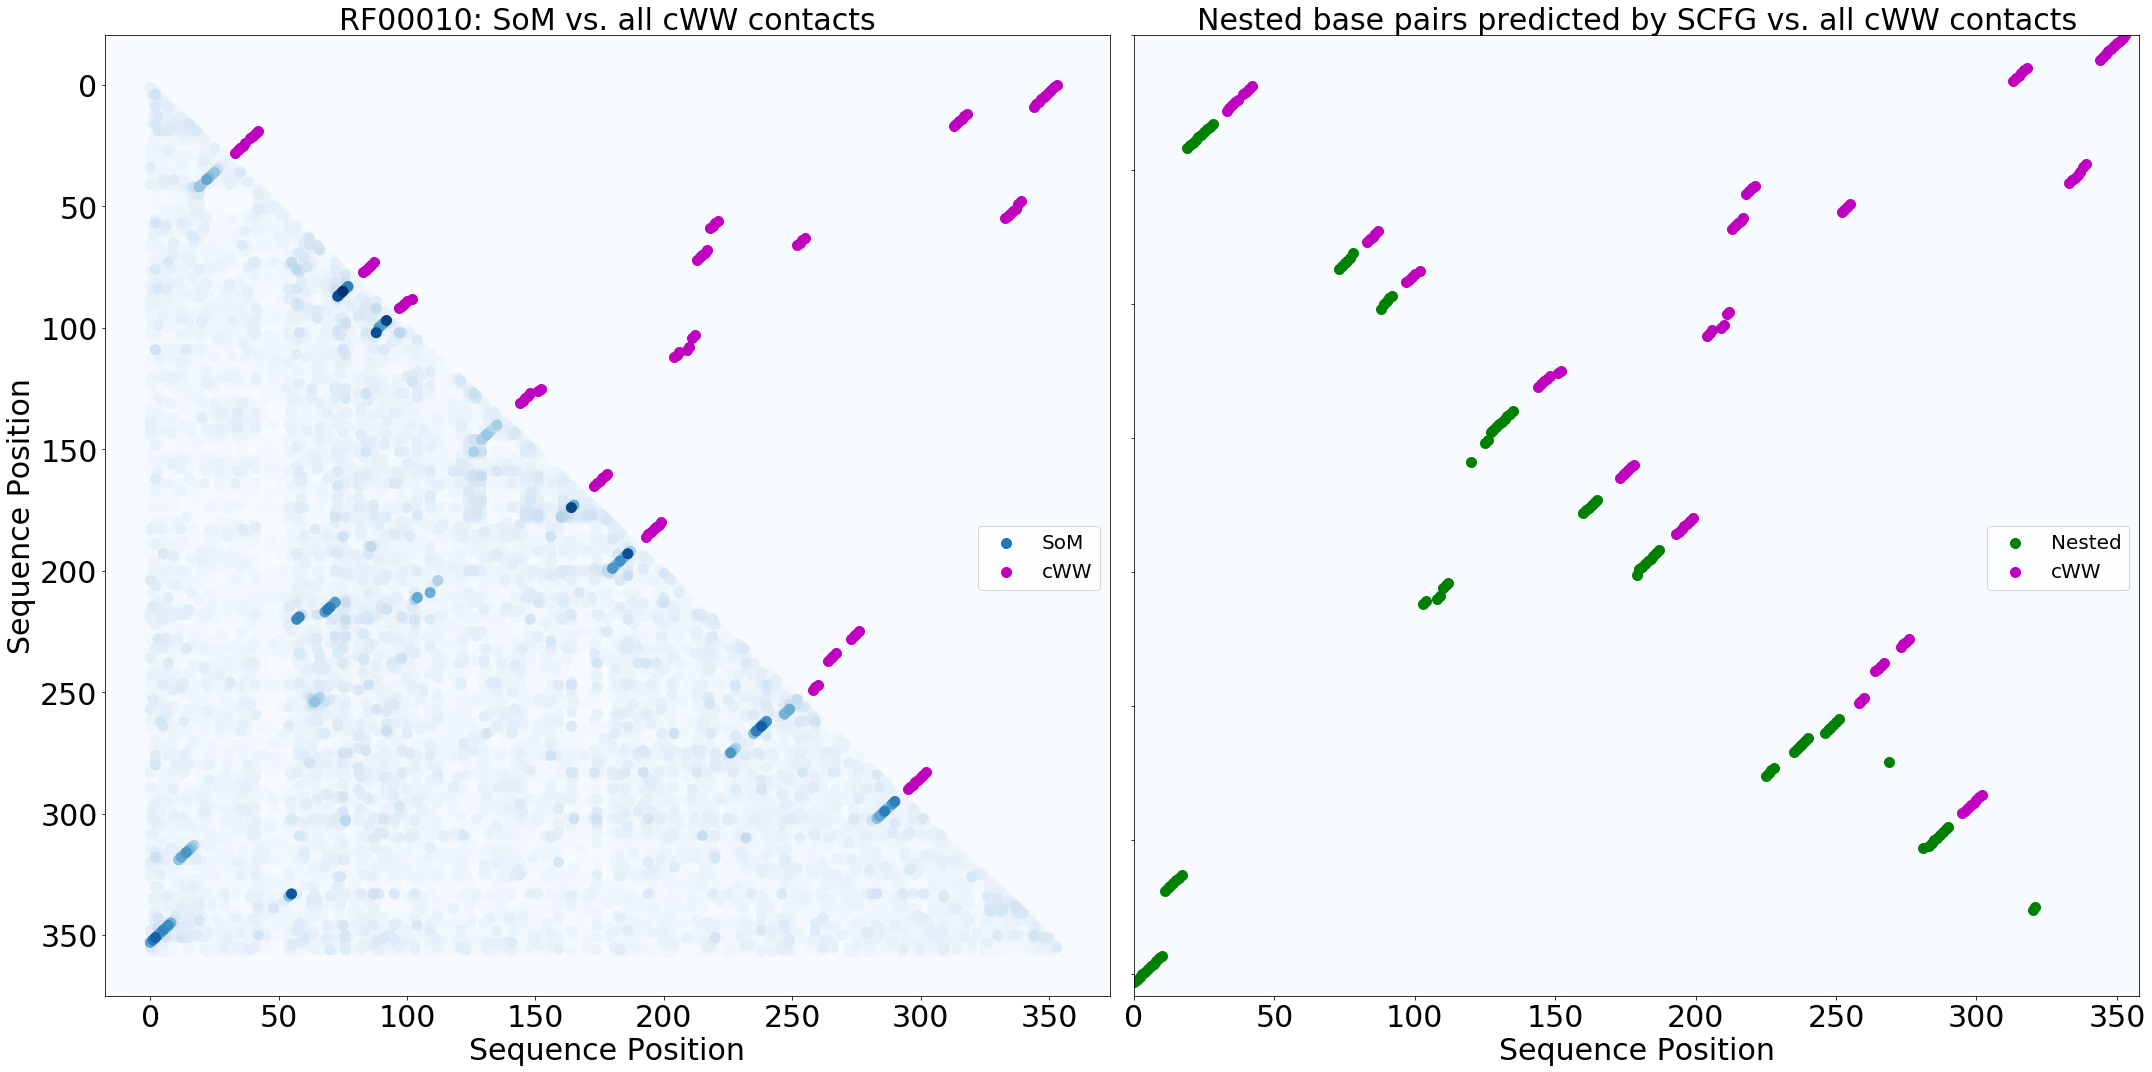

In [10]:

#get the colour map to select colors for plotting
pal = 'Blues'
cmap = mat.cm.get_cmap(pal)


markersize = 100

#plot
fig = plt.figure(figsize=(30,15))

ax1 = fig.add_subplot(1,2,1)
ax1.scatter(x, y, c=score_col, cmap=pal, label = 'SoM', vmin=0., s=markersize) #plot SoM results
ax1.scatter(cWW_int.iloc[:,2], cWW_int.iloc[:,1], c='m', label = 'cWW', s=markersize)
ax1.set_title('%s: SoM vs. all cWW contacts'%(fam), fontsize=30)
ax1.legend(loc='best', fontsize=20, bbox_to_anchor=(1., 0.5))
ax1.set_xlabel('Sequence Position', fontsize=30)
ax1.set_ylabel('Sequence Position', fontsize=30)
ax1.invert_yaxis()
ax1.set_facecolor(cmap(0.))
ax1.tick_params(axis='both', which='major', labelsize=30)

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(nest_coords[:, 0], nest_coords[:, 1], c='g', label = 'Nested', s=markersize)
ax2.scatter(cWW_int.iloc[:,2], cWW_int.iloc[:,1], c='m', label = 'cWW', s=markersize)
ax2.set_title('Nested base pairs predicted by SCFG vs. all cWW contacts', fontsize=30)
ax2.legend(loc='best', fontsize=20, bbox_to_anchor=(1., 0.5))
ax2.set_xlabel('Sequence Position', fontsize=30)
#ax2.set_ylabel('Sequence Position', fontsize=30)
ax2.set_xlim([0,seqlen])
ax2.set_ylim([0,seqlen])
ax2.invert_yaxis()
ax2.set_facecolor(cmap(0.))
ax2.set_yticklabels([])
ax2.tick_params(axis='both', which='major', labelsize=30)

plt.savefig('%s compared to nested.png'%(fam))
plt.show()